# EEG/MEG signal preprocessing - Part 2

#### Max Planck School of Cognition, Methods in Cognitive Neuroscience, June 2021


##### Contact: Mina Jamshidi Idaji @ Neurology Dept., MPI CBS, Leipzig, Germany, jamshidi@cbs.mpg.de


### Objectives

There are a number of automatic pipelines for denoising EEG/MEG; however, in many cases you should inspect your data manually. Therefore, the objectives of this notebook are:
* Getting to know the usual artifacts in EEG/MEG recordings.
* Going through a typical manual pipeline for cleaning EEG/MEG data from usual artifacts.
* There can be also side objectives for this tutorial: this is a good chance to deepen your Python skills. So, in case you have limited experience with Python, don't worry at all. I tried to explain coding details as well. If you are already familiar with Python, you can skip the "Coding Detail" sections.

### In the last tutorial:

* you will explore the MNE Python object Raw, which includes the sensor-space M/EEG data
* the following steps of pre-processing are covered in this tutorial: power-line noise cancellation, bad segments and channels

### In this tutorial:
* you will learn the ICA artifact rejection
* finalizing the EEG pre-processing pipeline.

--------------

### Packages and Data

Check the session 1 tutorial for this.

In [1]:
import mne  # MNE Python
from os.path import join  # this function is used to build the directories 
import numpy as np  # numpy is a library for working with matrices
import scipy.signal as sp  # scipy.signal implements the signal processing functions
# import matplotlib
# matplotlib.use('TKAgg')
from matplotlib import pyplot as plt  # matplotlib is the most common used package to do plotting in Python
from IPython.display import Video, Image
import eeg_tutorial_help_functions as hf  # help functions for this tutorial

# the backend of matplotlib for plotting interactive plots in jupyter notebook on jupyter hub of GWDG
%matplotlib widget  


--------------
--------------

The original data:

In [3]:
subject = 'sub-010088'

In [4]:
vhdr_fname = join('./Data', subject, subject + '.vhdr')  # build the directory of the data
# vhdr_fname = './Data/' + subject + '/' + subject + '.vhdr'  # this is an alternative to os.path.join

raw_orig = mne.io.read_raw_brainvision(vhdr_fname, preload=True)  # load the data
print(raw_orig)  # take a look at what we loaded

Extracting parameters from ./Data/sub-010088/sub-010088.vhdr...
Setting channel info structure...
Reading 0 ... 2702599  =      0.000 ...  1081.040 secs...
<RawBrainVision | sub-010088.eeg, 62 x 2702600 (1081.0 s), ~1.25 GB, data loaded>


## 2. Artifacts

Read the data with the bad segments marked.

In [5]:
raw_annot_fname = join('./Data', subject, subject + '-annotation-raw.fif')
raw = mne.io.read_raw_fif(raw_annot_fname)

raw.set_eeg_reference(projection=True)

Opening raw data file ./Data/sub-010088/sub-010088-annotation-raw.fif...
    Read a total of 1 projection items:
        Average EEG reference (1 x 61)  idle
    Range : 0 ... 132140 =      0.000 ...   528.560 secs
Ready.


<ipython-input-5-8658f43558b2>:4: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference(projection=True)


<Raw | sub-010088-annotation-raw.fif, 61 x 132141 (528.6 s), ~93 kB, data not loaded>

---

### 2.3. Artifacts: Eye, muscle, and heart artifacts

Now that we got rid of the power-line noise and bad segments, let's take another look at the PSD. 

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Setting 4952 of 132141 (3.75%) samples to NaN, retaining 127189 (96.25%) samples.
Effective window size : 1.024 (s)


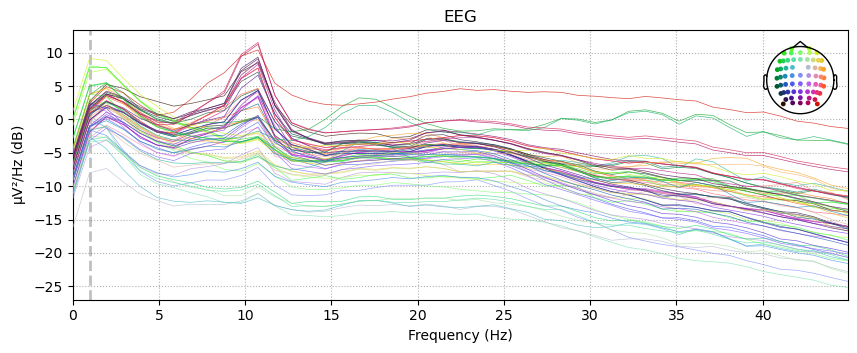

In [6]:
freq_res = 1  # frequency resolution
nfft = (2 ** np.ceil(np.log2(raw.info['sfreq'] / freq_res))).astype(int)
raw.plot_psd(fmin=0, fmax=45, n_fft=nfft, picks='all', reject_by_annotation=True)

* The first abnormality that we can observe is in the low-frequency band: two channels (Fp1, Fp2) have very high power in low-frequency. This is a typical sign of eye moverment and eye blink. You can zoom into the low-frequency bands using the zoom option in the above interactive graph.

* The second noise signs in the PSD are the channels with high-frequency power. You see some channels *flying* - instead of decaying, they are horizontal or going up. These channels are contaminated by muscle noise.

We use Independent Component Analysis (ICA) for separating these artifacts and removing them. I find <a href='https://mne.tools/stable/auto_tutorials/preprocessing/plot_40_artifact_correction_ica.html#sphx-glr-auto-tutorials-preprocessing-plot-40-artifact-correction-ica-py'>this MNE tutorial</a> useful.

In [7]:
from mne.preprocessing import ICA

There are different methods of ICA. The two mostly used ones are infomax and fastICA. As its name suggests, fastICA is much faster. However, the EEG community using EEGLAB in MATLAB are used to infomax-extended. I would say for the purpose we have, their results are comparable.

In [8]:
n_components = 32  # number of ICA compoentns 
method = 'infomax' # can be 'fastica' as well
random_state = 3459  # this is just to produce exactly the same result each time this tutorial is run
fit_params = dict(extended=True)  # here it is for infomax-extended method
ica = ICA(n_components=n_components, method=method, random_state=random_state, fit_params=fit_params)  # build an object of ICA class

<ipython-input-8-4744f13b6da1>:5: DeprecationWarning: Version 0.23 introduced max_iter="auto", setting max_iter=1000 for `fastica` and max_iter=500 for `infomax` and `picard`. The current default of max_iter=200 will be changed to "auto" in version 0.24.
  ica = ICA(n_components=n_components, method=method, random_state=random_state, fit_params=fit_params)  # build an object of ICA class


Now you can compute the ICA components for the raw object. This is done using the `fit` method of ICA class:

WARNING: Infomax takes some time. fastICA ist faster, as its name says ;-)

In [9]:
picks = mne.pick_types(raw.info, eeg=True, meg=False, exclude='bads')
ica.fit(raw, picks=picks, reject_by_annotation=True)  # compute ICA components for raw

Fitting ICA to data using 61 channels (please be patient, this may take a while)
Omitting 4952 of 132141 (3.75%) samples, retaining 127189 (96.25%) samples.
Selecting by number: 32 components
Computing Extended Infomax ICA
Fitting ICA took 45.0s.


<ICA | raw data decomposition, fit (infomax): 127189 samples, 32 components, channels used: "eeg">

I've run ICA already and saved it:

In [10]:
raw_ica_fname = join('./Data', subject, subject + '-' + str(n_components) + '-' + method +'-ica.fif')
ica.save(raw_ica_fname)
#ica = mne.preprocessing.read_ica(raw_ica_fname)

Writing ICA solution to ./Data/sub-010088/sub-010088-32-infomax-ica.fif...


<ICA | raw data decomposition, fit (infomax): 127189 samples, 32 components, channels used: "eeg">

ICA decomposes data $\mathbf{X}$ as $\mathbf{X} = \mathbf{A} \mathbf{S}$. We can get the sources $\mathbf{S}$ and their mixing matrix $\mathbf{A}$ with methods `get_sources()` and `get_components()` respectively.

In [11]:
src = ica.get_sources(raw)
src = src.get_data()
mixing_mat = ica.get_components()
print(src.shape)
print(mixing_mat.shape)

(32, 132141)
(61, 32)


You can see that 32 ICA components are extracted, this is equal to the parameter `n_components` that we determined before. 

We can plot the topographies of the components (i.e. the columns of the mixing matrix) uisng `plot_components`.

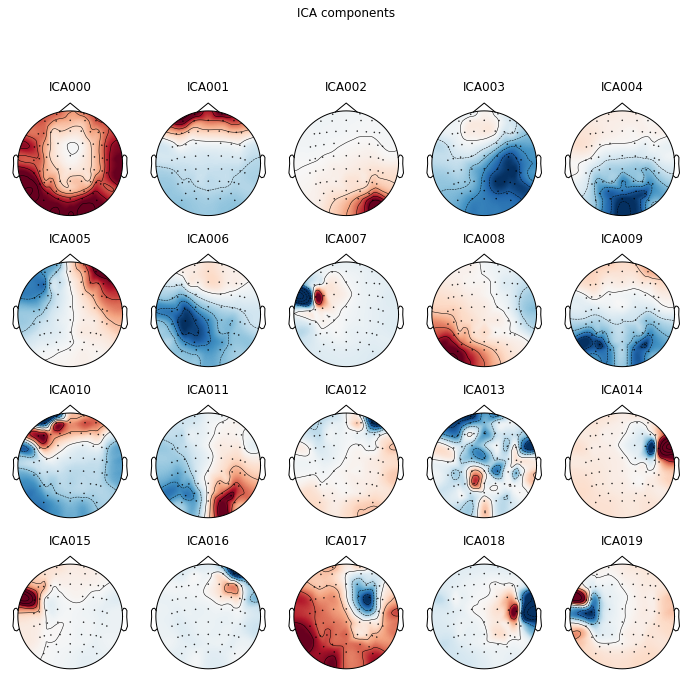

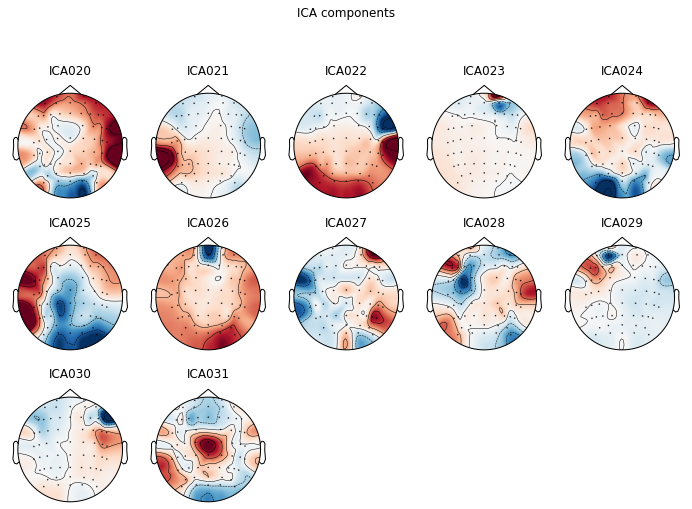

[<MNEFigure size 702x696.24 with 20 Axes>,
 <MNEFigure size 702x526.68 with 12 Axes>]

In [12]:
%matplotlib inline
ica.plot_components(inst=raw)

To get an imagination of the channels, look at this figure, which shows the 10-20 system:

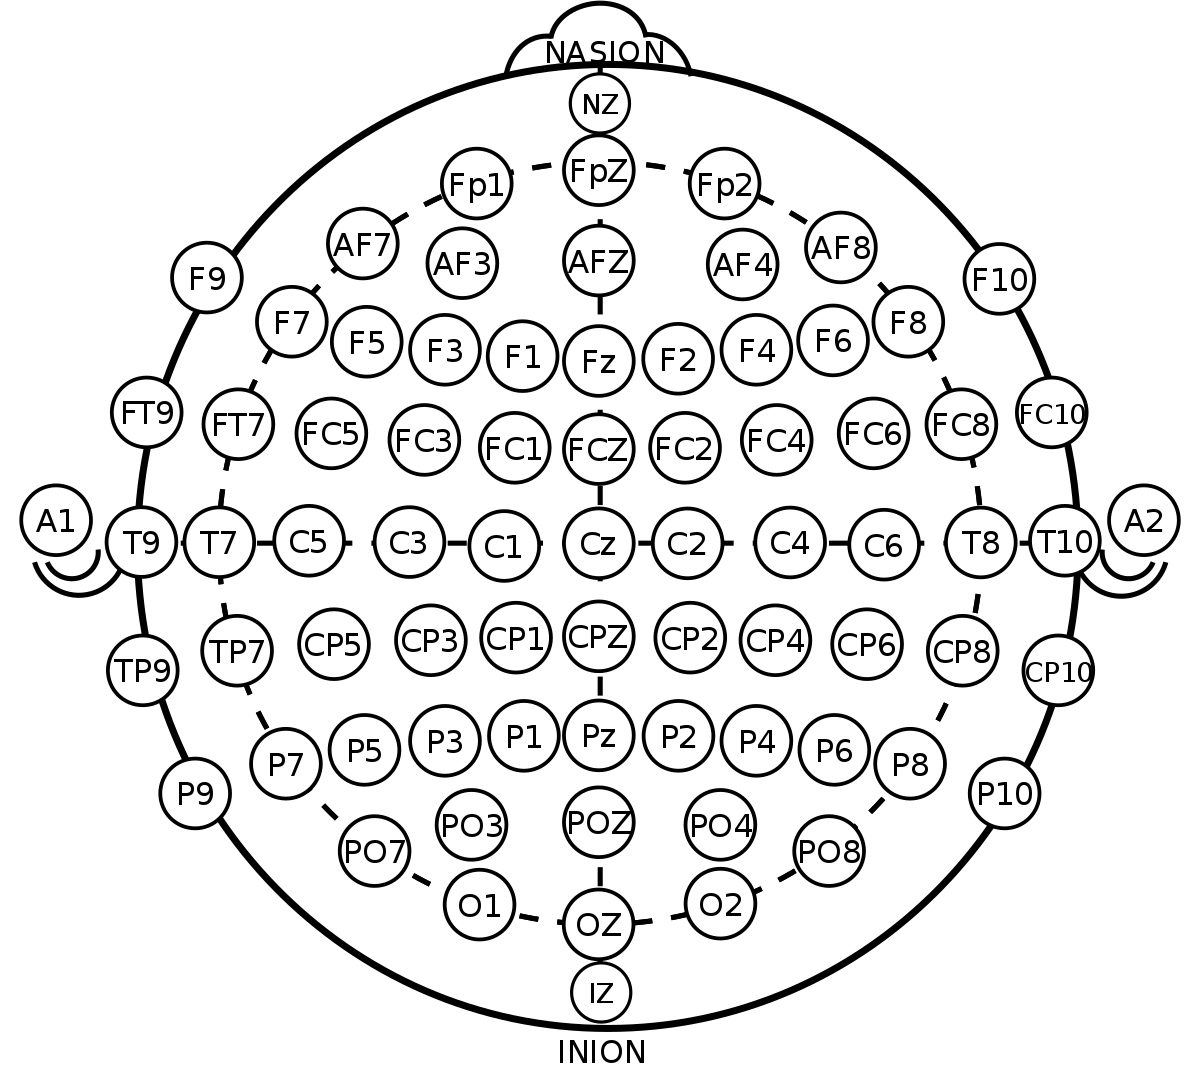

In [13]:
Image('10-20-EEG.png', width=500)
# Ref: https://commons.wikimedia.org/wiki/File:International_10-20_system_for_EEG-MCN.svg

... and the time series of the components uisng `plot_sources`. By clicking on the times series of a source, you can mark it as a bad compoenent (Component will change to red color). By clicking on the name of a component, its topography will be plotted (Unfortunately, this is not possible in Jupyterhub).

For adding a new component to the list of bad components: 
* You can use the interactive window of `ica.plot_sources` by clicking on the time-series of the bad component (their color becomes red) and then pressing esc. Afterwards, when you look at `ica.exclude` by `print(ica.exclude)`, you see that those component numbers are saved as a list in this attribute.
    * **Note**: On jupyter hub with `%matplotlib notebook` after selecting the bad components on the interactive window, instead of pressing esc you should run the code cell including `ica.plot_sources(inst=raw)` again.
    
* You can modified `ica.exclude` manually without the interactive window. In order to add a component with index `n` to the exclude list:
    
        ica.exclude += [n]
    
    If you want to add multiple components:
    
        ica.exclude += [n, m, p, q]

    If you wanna delete the i-th entry of the exclude list:
    
        del ica.exclude[i]


When you plotted the source signals, continue with the tutorial and you will see which components should be marked as bad ones, and why.

Creating RawArray with float64 data, n_channels=32, n_times=132141
    Range : 0 ... 132140 =      0.000 ...   528.560 secs
Ready.


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

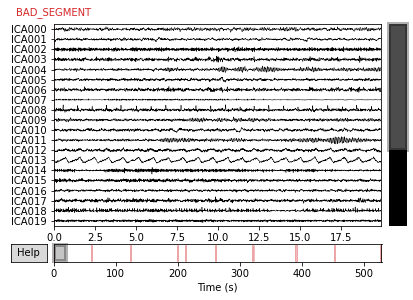

In [14]:
%matplotlib widget
ica.plot_sources(inst=raw)

We use the topographies, the time series and their PSD to decide if a component should be rejected.

**EXERCISE 5**: Take a look at <a href='https://labeling.ucsd.edu/tutorial/labels'>this EEGLab tutorial</a>. 

Optional: Paper [4] is also a very good reference.

From the topography, we can see that component 1 is eye blink and component 5 is eye movement artifact. Look at the PSDs:

In [45]:
ax = hf.plot_psd(src[[1, 5], :], fs=raw.info['sfreq'], f_max=45)
plt.title('PSD of the two eye artifact componentns. Compnents 1 and 5')
# plt.plot(raw._times, src[[1, 5], :])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Text(0.5, 1.0, 'PSD of the two eye artifact componentns. Compnents 1 and 5')

You can see that both of them have high power in low frequency band. So, either click on the time series of component #1 in the window of `ica.plot_components` or run the code below:

In [16]:
ica.exclude += [1, 5]
print(ica.exclude)

[1, 5]


Component 4 is interesting to look at. Its time seris shows us that nice occipital alpha source ([8-12]Hz) with beta harmonics (~20Hz). Look at the PSD:

In [17]:
ax = hf.plot_psd(src[4:5, :], fs=raw.info['sfreq'], f_max=45)
plt.title('PSD of the component 4')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Text(0.5, 1.0, 'PSD of the component 4')

Its PSD looks like a typical beautiful PSD, with alpha and beta peak.

The time-series of component 8 shows a clear presence of heart beat. Do you see the R peaks of ECG? Its topography also represents the typical heart artifact topography with a linear scalp map gradient. So, either click on the time series of component #8 in the window of `ica.plot_components` or run the code below:


In [18]:
ica.exclude += [8]
print(ica.exclude)

[1, 5, 8]


**EXERCISE 6**: Determine another good alpha source. Plot the PSD. 

**YOUR ANSWER:** (type it in the cell below)

In [ ]:
# TO BE COMPLETED BY STUDENTS ------------------
# ANSWER TO EXERCISE 6

# ---------------------------------------------

The time-series and topographies of components 14-16 and 18, 19 look like muscle activity. Let's look at the PSDs:

In [19]:
cmp_rej = np.append(np.arange(14,17), np.arange(18,20))
ax = hf.plot_psd(src[cmp_rej, :], fs=raw.info['sfreq'], f_max=45)
plt.title('PSD of some muscle artifact componentns.')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Text(0.5, 1.0, 'PSD of some muscle artifact componentns.')

You can see that all of them have high power in high-frequency and low power in low frequency bands. I always look at those PSD lines as if they are flying! Btw, if you look at the time-series of these components, you see that all of them have very low amplitudes and then suddenly they become noisy at around 137.5 (s). Now using 'raw.plot()' plot the raw data and go to around this time point:

In [ ]:
raw.plot()

You see that some channels become noisy exactly around this time. 

**EXERCISE 7:** Which channels become noisy around 137.5 (s)? Could you find a relationship between these channels and the topography of ICA components 7 and 17-20? Use the figure of 10-20 system to locate the channels on the head and compare it with the ICA component topographies.

**YOUR ANSWER:** (type your answer here) ?

So, either click on the time series of component 14-16 and 18, 19 in the window of `ica.plot_components` or run the code below:

In [20]:
ica.exclude += list(np.arange(14, 17))
ica.exclude += list(np.arange(18, 20))
print(ica.exclude)

[1, 5, 8, 14, 15, 16, 18, 19]


If you also look at component 22, the time seris looks very noisy. But the topography is not focal. That tells us that the source is a mixture of noise and brain signals. Look at the PSD:

In [21]:
ax = hf.plot_psd(src[22:23, :], fs=raw.info['sfreq'], f_max=45)
plt.title('PSD of compnent 22')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Text(0.5, 1.0, 'PSD of compnent 22')

It has a peak at alpha band. I would for now keep that component. 

For now, let's look at the PSD of our multichannel signal when we remove these components that we selected. n many cases we have to go back and select more bad components.   


In [22]:
print(ica.exclude)

[1, 5, 8, 14, 15, 16, 18, 19]


Reading 0 ... 132140  =      0.000 ...   528.560 secs...
Applying ICA to Raw instance
    Transforming to ICA space (32 components)
    Zeroing out 8 ICA components
    Projecting back using 61 PCA components


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Setting 4952 of 132141 (3.75%) samples to NaN, retaining 127189 (96.25%) samples.
Effective window size : 1.024 (s)


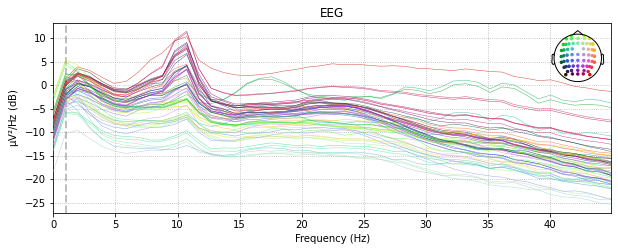

In [23]:
raw.load_data()
raw_ica_1 = raw.copy()  # make a new version of raw that ica bad component rejection will be applied on it
ica.apply(raw_ica_1)  # apply the ICA bad component rejection on raw

# plot the PSD of cleaned data
freq_res = 1
nfft = (2 ** np.ceil(np.log2(raw_ica_1.info['sfreq'] / freq_res))).astype(int)
raw_ica_1.plot_psd(fmin=0, fmax=45, n_fft=nfft, picks='all')

Note that you have to copy the raw object into a new object so that you don't loose it when applying ica to it.

**EXERCISE 8:** You can see a couple of channels which are flying! They are noisy with muscle artifact. Using the interactive window of `plot_psd`, determine these three channels. Look at the figure of 10-20 EEG system. Where are they located? Can you determine the ICA components corresponding to this noise source? Plot their PSD and add it to the bad ICA components list.

**YOUR ANSWER**: (type your answer here and use the cell below for your codes) ?

In [47]:
# TO BE COMPLETED BY STUDENTS ------------------
# ANSWER TO EXERCISE 8
ica.exclude += [10, 12]
# ---------------------------------------------

**Assuming that you marked the new bad component - if not: copy the answer from the solution notebook**, we reject the bad ICA components again:

Applying ICA to Raw instance
    Transforming to ICA space (32 components)
    Zeroing out 12 ICA components
    Projecting back using 61 PCA components


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Setting 4952 of 132141 (3.75%) samples to NaN, retaining 127189 (96.25%) samples.
Effective window size : 1.024 (s)


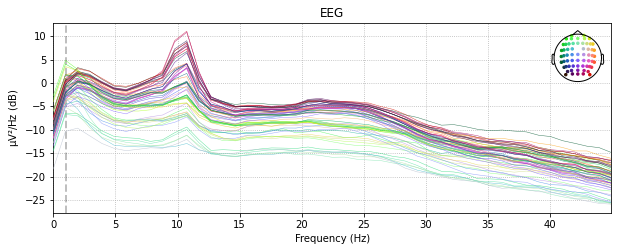

In [48]:
raw.load_data()
raw_ica_2 = raw.copy()
ica.apply(raw_ica_2)
freq_res = 1
nfft = (2 ** np.ceil(np.log2(raw_ica_2.info['sfreq'] / freq_res))).astype(int)
raw_ica_2.plot_psd(fmin=0, fmax=45, n_fft=nfft, picks='all')

You can see that those three channels are now behaving normal!

As an example, let's compare the PSD of channel PO8 before and after removing the last ICA component.

In [50]:
ind_PO8 = raw.info['ch_names'].index('PO8')
data_1 = raw_ica_1.get_data()[ind_PO8, :][np.newaxis, :] * 1e6
data_2 = raw_ica_2.get_data()[ind_PO8, :][np.newaxis, :] * 1e6
data_plot = np.append(data_1, data_2, axis=0)
ax = hf.plot_psd(data_plot, raw.info['sfreq'], f_max=45)
ax.legend(['before', 'after'])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

You can see how well the muscle noise has been removed. You can also clearly see that we have lost some of our alpha power.

Now it is the time to scroll over the time-series of the cleaned data: 

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

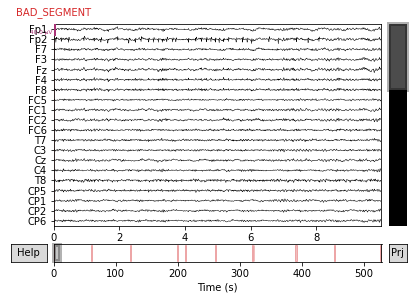

In [49]:
# %matplotlib tk
raw_ica_2.plot()

**EXERCISE 10:** write some differences between the PSDs and time-series of before and after ICA artifact rejection. You may use `raw.plot()` and `raw.plot_psd()`.

**YOUR ANSWER**: (type your answer here and use the cell below for your codes)?

In [ ]:
# TO BE COMPLETED BY THE STUDENT -------------------------
# ANSWER TO EXERCISE 9 
# ?
# ----------------------------------------------------------

The bad segments that we marked before are still noisy. The reason is that they are excluded in ICA step. We also usually exclude these bad segments for the rest of the analysis.  

In [ ]:
data_clean = raw_ica_2.get_data(reject_by_annotation='omit')
raw_clean = mne.io.RawArray(data_clean, raw_ica_2.info)

### References

[1] https://mne.tools/stable/index.html

[2] Babayan, A. et al. (2019) A mind-brain-body dataset of MRI, EEG, cognition, emotion, and peripheral physiology in young and old adults. Sci. Data. 6:180308 https://doi.org/10.1038/sdata.2018.308.

[3] https://mne.tools/stable/auto_tutorials/io/plot_20_reading_eeg_data.html#brainvision-vhdr-vmrk-eeg

[4] Maximilien Chaumon, Dorothy V.M. Bishop, Niko A. Busch (2015) A practical guide to the selection of independent components of the electroencephalogram for artifact correction, Journal of Neuroscience Methods, Volume 250, pp 47-63, https://doi.org/10.1016/j.jneumeth.2015.02.025.